In [25]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import time

In [2]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [4]:
data = pd.read_csv('event-api-request-count.csv')
print(data.head())

                   timestamp  request count
0  2017-10-25 00:00:00+00:00       120737.0
1  2017-10-25 00:01:00+00:00       122841.0
2  2017-10-25 00:02:00+00:00       123191.0
3  2017-10-25 00:03:00+00:00       126607.0
4  2017-10-25 00:04:00+00:00       126193.0


In [5]:
print('\n Data Types:')
print(data.dtypes)


 Data Types:
timestamp         object
request count    float64
dtype: object


In [33]:
dateparse = lambda dates: pd.datetime.strptime(dates[:19], '%Y-%m-%d %H:%M:%S')

datetime.datetime(2017, 10, 25, 0, 4)

In [34]:
data = pd.read_csv('event-api-request-count.csv', parse_dates=['timestamp'], index_col='timestamp',date_parser=dateparse)

In [36]:
data.index

DatetimeIndex(['2017-10-25 00:00:00', '2017-10-25 00:01:00',
               '2017-10-25 00:02:00', '2017-10-25 00:03:00',
               '2017-10-25 00:04:00', '2017-10-25 00:05:00',
               '2017-10-25 00:06:00', '2017-10-25 00:07:00',
               '2017-10-25 00:08:00', '2017-10-25 00:09:00',
               ...
               '2017-11-07 23:50:00', '2017-11-07 23:51:00',
               '2017-11-07 23:52:00', '2017-11-07 23:53:00',
               '2017-11-07 23:54:00', '2017-11-07 23:55:00',
               '2017-11-07 23:56:00', '2017-11-07 23:57:00',
               '2017-11-07 23:58:00', '2017-11-07 23:59:00'],
              dtype='datetime64[ns]', name='timestamp', length=20156, freq=None)

In [46]:
ts = data['request count']

In [47]:
ts.head()

timestamp
2017-10-25 00:00:00    120737.0
2017-10-25 00:01:00    122841.0
2017-10-25 00:02:00    123191.0
2017-10-25 00:03:00    126607.0
2017-10-25 00:04:00    126193.0
Name: request count, dtype: float64

In [51]:
ts = ts[ ts.index > '2017-11-01 01:00:00']

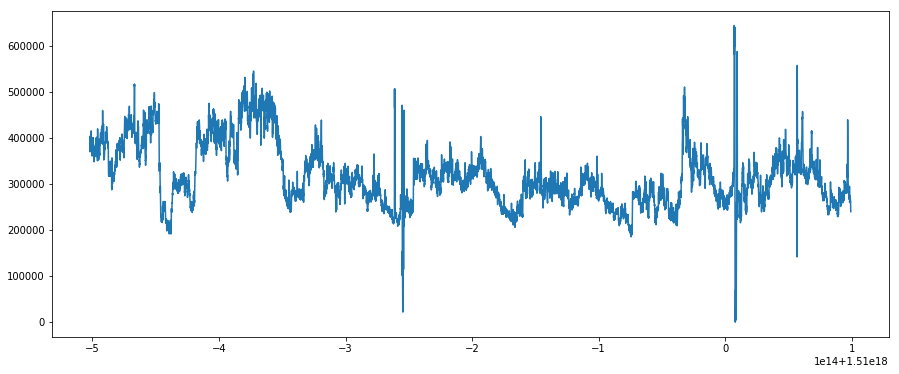

In [52]:
plt.plot(ts)

In [54]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [60]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=1440)
    rolstd = pd.rolling_std(timeseries, window=1440)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1440,center=False).mean()
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1440,center=False).std()
  """


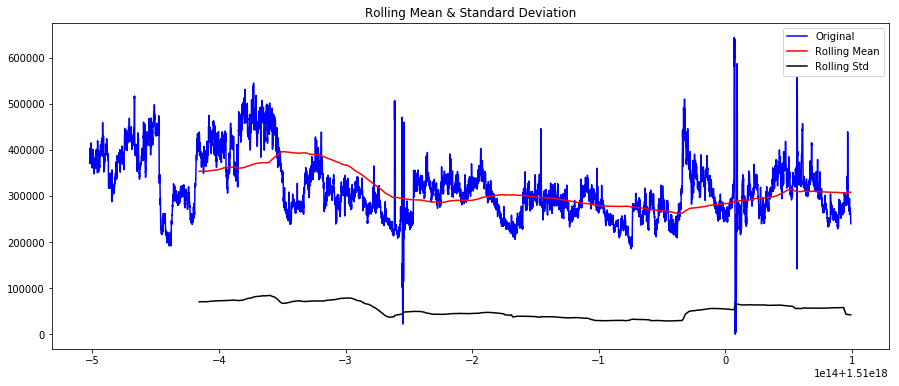

Results of Dickey-Fuller Test:
Test Statistic                   -4.564538
p-value                           0.000150
#Lags Used                       38.000000
Number of Observations Used    9976.000000
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
Critical Value (1%)              -3.431006
dtype: float64


In [61]:
test_stationarity(ts)